In [1]:
from nmm import csolve,OhmicBath,OverdampedBath
from qutip import Qobj,sigmaz,sigmax,sigmay
import numpy as np
import matplotlib.pyplot as plt

In [2]:
w0 = 1
alpha = 0.01
gamma = w0
T = 1*w0
tf = 40
t=np.linspace(0,tf,200)
Hsys = sigmaz()/2
Q = sigmax()

In [3]:
bath=OhmicBath(T,alpha,gamma)
bath2 = OhmicBath(2*T,alpha,gamma)

In [4]:
bath.power_spectrum(1)

0.01163953413738653

In [5]:
bath2.power_spectrum(1)

0.018699268456483297

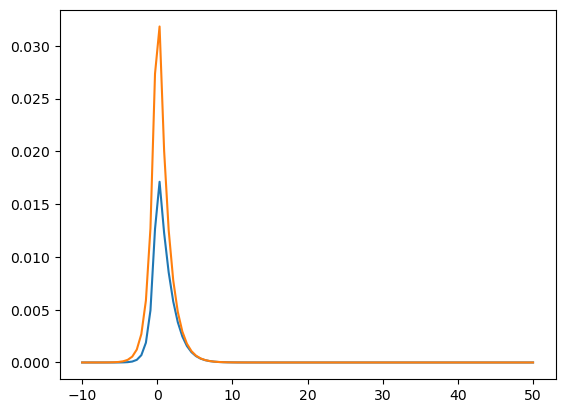

In [6]:
w=np.linspace(-10,50,100)
plt.plot(w,bath.power_spectrum(w))
plt.plot(w,bath2.power_spectrum(w))
plt.show()

In [7]:
#cc = csolve(Hsys,t ,[bath,bath2], [Q,Q])
cc2 = csolve(Hsys, t ,[bath,bath2], [Q,Q])

In [8]:
rho0=0.5*Qobj([[1,1],[1,1]])

In [9]:
result=cc2.evolution(rho0)
#result2=cc.evolution(rho0)

2


Calculating Integrals ...:   0%|          | 0/4 [00:00<?, ?it/s]

Calculating the generator ...: 100%|██████████| 4/4 [00:00<00:00, 146.34it/s]


2


Computing Exponential of Generators . . . .: 100%|██████████| 200/200 [00:00<00:00, 927.52it/s] 


In [10]:
cc2.generators[10]

Quantum object: dims=[[[2], [2]], [[2], [2]]], shape=(4, 4), type='super', isherm=False
Qobj data =
[[-0.16365196+0.j          0.        +0.j          0.        +0.j
   0.12192502+0.j        ]
 [ 0.        +0.j         -0.14278849+0.j         -0.04791404-0.10197309j
   0.        +0.j        ]
 [ 0.        +0.j         -0.04791404+0.10197309j -0.14278849+0.j
   0.        +0.j        ]
 [ 0.16365196+0.j          0.        +0.j          0.        +0.j
  -0.12192502+0.j        ]]

In [11]:
def population(den, a, b):
    return [den[i][a, b] for i in range(len(den))]

In [12]:
# bath = DrudeLorentzPadeBath(Q=Q, lam=alpha*np.pi, gamma=gamma, T=T, Nk=8)
# solver = HEOMSolver(Hsys, bath, max_depth=5)
# result_h = solver.run(rho0, t)

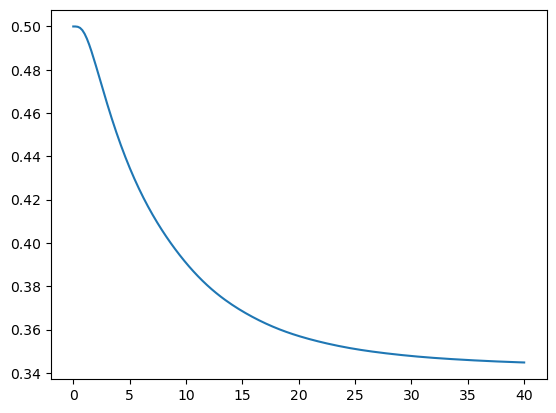

In [15]:
i,j=0,0
plt.plot(t,np.abs(population(result,i,j)))
#plt.plot(t, np.abs(population(result2, i, j)))
# plt.plot(t, np.abs(population(result_h.states, 0, 1)))
# plt.show()

In [16]:
from qutip import brmesolve

In [17]:
def br(rho0,sec=-1):
    DL2 = (
        f"{4*alpha/(gamma)} if (w == 0) else "  # Just taking both limits -> spectral density for pure dephasing
        f"{alpha} *2*pi*w *exp(-abs(w)/{gamma}) * ((1/(exp( w*{1/T})-1))+1)"  # f"2*pi*(2.0 *{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {w/T})-1))+1)"
    )
    DL1 = (
        f"{4*alpha/(gamma)} if (w == 0) else "  # Just taking both limits -> spectral density for pure dephasing
        f"{alpha} *2*pi*w *exp(-abs(w)/{gamma}) * ((1/(exp( w*{1/(2*T)})-1))+1)"  # f"2*pi*(2.0 *{lam}*{gamma} *w /(pi*(w**2+{gamma}**2))) * ((1/(exp((w) * {w/T})-1))+1)"
    )
    a_ops = [[Q,DL1],[Q,DL2]]
    resultBR = brmesolve(
        Hsys, rho0, t, a_ops=a_ops,sec_cutoff=sec
    )
    return resultBR

In [18]:
resultBR=br(rho0)

/home/mcditoos/qutip_gsoc_app/qutip/core/coefficient.py:386: UserWarning: Both `cython` and `filelock` are required for compilation of string coefficents. Falling back on `eval`.
  warnings.warn(


In [19]:
i,j=0,0

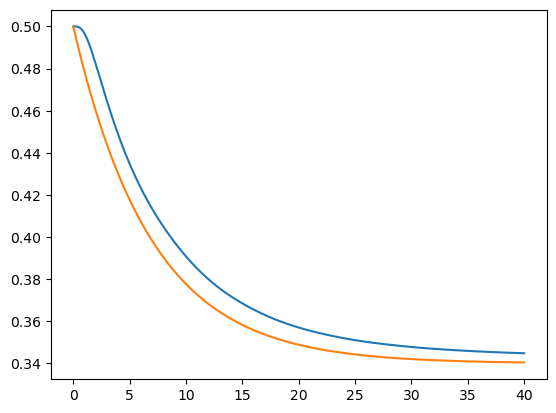

In [20]:
plt.plot(t, np.abs(population(result, i, j)))
plt.plot(t, np.abs(population(resultBR.states, i, j)))
#plt.plot(t, np.abs(population(resultBR2.states, i, j)))

plt.show()


In [21]:
from qutip.solver import heom

In [22]:
obp=heom.SpectralFitter(T,Q,w,bath.spectral_density(w)*np.pi)
obp2=heom.SpectralFitter(2*T,Q,w,bath.spectral_density(w)*np.pi)


In [23]:
bathf,fit_info=obp.get_fit(N=7,Nk=4)
bathf2,fit_info=obp2.get_fit(N=7,Nk=2)

fit_info

{'fit_time': 15.081664800643921,
 'rmse': 4.257402861182969e-07,
 'N': 7,
 'params': [array([ 0.05342256,  0.12939288, -0.00975855, -0.11115949,  0.11327511,
         -0.0383884 , -0.09667202]),
  array([2.73067497, 2.82539289, 4.42310786, 3.0024889 , 1.08028618,
         4.01121618, 1.03611671]),
  array([0.23376132, 0.15584068, 5.65503087, 0.09092566, 0.17705923,
         3.31696788, 0.27410622])],
 'Nk': 2,
 'summary': 'Result of fitting The Spectral Density with 7 terms: \n \n Parameters|   lam    |  gamma   |   w0 \n 1         | 5.34e-02 | 2.73e+00 |2.34e-01\n 2         | 1.29e-01 | 2.83e+00 |1.56e-01\n 3         |-9.76e-03 | 4.42e+00 |5.66e+00\n 4         |-1.11e-01 | 3.00e+00 |9.09e-02\n 5         | 1.13e-01 | 1.08e+00 |1.77e-01\n 6         |-3.84e-02 | 4.01e+00 |3.32e+00\n 7         |-9.67e-02 | 1.04e+00 |2.74e-01\n \nA  normalized RMSE of  4.26e-07 was obtained for the The Spectral Density\n The current fit took  15.081665 seconds'}

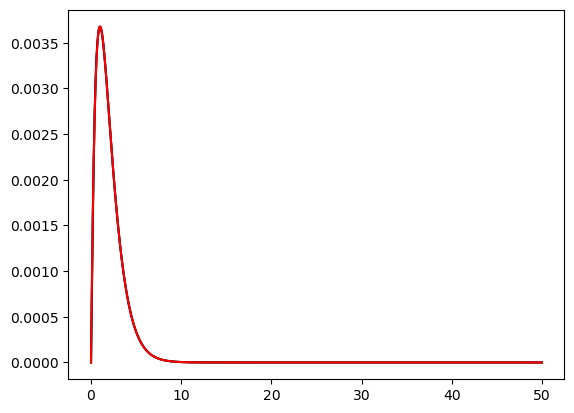

In [25]:
w=np.linspace(0,50,1000)
plt.plot(w,bathf.spectral_density_approx(w)/np.pi)
plt.plot(w,bathf2.spectral_density_approx(w)/np.pi,color='k')
plt.plot(w,bath.spectral_density(w),color='r')

In [26]:
solver = heom.HEOMSolver(Hsys,[bathf2,bathf],max_depth=3)

In [27]:
result_heom=solver.run(rho0,t)

10.1%. Run time:   5.42s. Est. time left: 00:00:00:48
20.1%. Run time:  10.94s. Est. time left: 00:00:00:43
30.2%. Run time:  16.33s. Est. time left: 00:00:00:37
40.2%. Run time:  20.64s. Est. time left: 00:00:00:30
50.3%. Run time:  28.19s. Est. time left: 00:00:00:27
60.3%. Run time:  34.41s. Est. time left: 00:00:00:22
70.4%. Run time:  40.81s. Est. time left: 00:00:00:17
80.4%. Run time:  47.42s. Est. time left: 00:00:00:11
90.5%. Run time:  55.19s. Est. time left: 00:00:00:05
100.0%. Run time:  62.37s. Est. time left: 00:00:00:00
Total run time:  62.37s


In [28]:
from scipy import linalg

In [29]:
def rotation(data, t, diagonal=True):
    rotated = [
        linalg.expm(-(1j * Hsys.full()) * t[i])
        @ data[i].full()
        @ linalg.expm((1j * Hsys.full()) * t[i])
        for i in range(len(t))
    ]
    return rotated

cum=rotation(result,t)

In [30]:
import qutip as qt

In [31]:
n1=bath.bose(w0)
n2=bath2.bose(w0)
spc=bath.spectral_density(w0)
Q1=(sigmax()+1j*sigmay())/2
c_ops=[np.sqrt(2*np.pi*(n1)*spc)*(Q1),np.sqrt(2*np.pi*(n1+1)*spc)*(Q1.dag()),
       np.sqrt(2*np.pi*(n2)*spc)*(Q1),np.sqrt(2*np.pi*(n2+1)*spc)*(Q1.dag())]
result_lindblad = qt.mesolve(Hsys, rho0, t, c_ops)

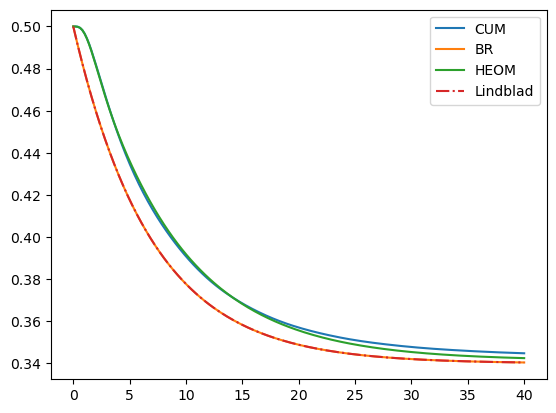

In [32]:
i,j=0,0
plt.plot(t, np.real(population(cum, i, j)),label='CUM')
plt.plot(t, np.real(population(resultBR.states, i, j)),label='BR')
plt.plot(t, np.real(population(result_heom.states, i, j)),label='HEOM')
plt.plot(t, np.real(population(result_lindblad.states, i, j)),'-.',label='Lindblad')
#plt.axhline(y=0.339921666085097,linestyle='-.')
plt.legend()
plt.show()

In [39]:
%timeit cc2.Γgen(bath,1,1,50)

56 ms ± 8.75 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [41]:
%timeit cc2.Γgen(bath,1,1,50,approximated=True)

154 µs ± 10 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [43]:
%timeit cc2.Γgen(bathf,1,1,50,matsubara=True)

/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/nmm-0.0.1-py3.12.egg/nmm/cumulant/cumulant.py:137: RuntimeWarning: overflow encountered in scalar multiply
  result+= coeff*np.sin(0.5*t*coeff1)*np.sin(0.5*t*coeff2)/(coeff1*coeff2)
/home/mcditoos/anaconda3/envs/qutip-dev/lib/python3.12/site-packages/nmm-0.0.1-py3.12.egg/nmm/cumulant/cumulant.py:137: RuntimeWarning: invalid value encountered in scalar multiply
  result+= coeff*np.sin(0.5*t*coeff1)*np.sin(0.5*t*coeff2)/(coeff1*coeff2)


274 µs ± 64.2 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [44]:
cc2.Γgen(bathf,1,1,50,matsubara=True)

(nan+nanj)

In [46]:
from qutip.solver.heom import BathExponent

In [78]:
bathf.exponents

[<BathExponent type=RI dim=None Q.dims=[[2], [2]] ck=(0.006932207570960282-0.011738539853403424j) vk=(2.730674973649431-0.23376131741554337j) ck2=0.0571336627334864j sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=RI dim=None Q.dims=[[2], [2]] ck=(0.006932207570960282+0.011738539853403424j) vk=(2.730674973649431+0.23376131741554337j) ck2=-0.0571336627334864j sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2], [2]] ck=(-0.0019042720444834127+0j) vk=6.283185307179586 ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2], [2]] ck=(-3.953739210596792e-05+0j) vk=12.566370614359172 ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2], [2]] ck=(-5.147709848403687e-06+0j) vk=18.84955592153876 ck2=None sigma_bar_k_offset=None fermionic=False tag=None>,
 <BathExponent type=R dim=None Q.dims=[[2], [2]] ck=(-1.4371456716665662e-06+0j) 

In [79]:
result

(-4.409718001991968e+44+2.0886136582674106e+45j)

In [60]:
coeff

(-0.13449745733181534-0.1436181064095263j)

In [52]:
coeff1*coeff2

(0.5498088125693676-2.640245497098985j)

In [53]:
coeff

(-0.13449745733181534-0.1436181064095263j)